# Hillary vs Clinton Tweets Dataset Analysis
## Sentimental, Topical and Correlation analysis

In this project, we will explore tweets done between 12/6/2016 and 12/9/2016 in an effort to understand "What happened?!". We will go over sentimental analysis of the tweets, the kind of topics discussed and the correlation analysis with result of the election.

## The questions we are exploring:

- What is the sentiment towards the candidates?
- Where are the candidates more popular?
- Which topics are the candidates and their supporters talking about?
- How big is the divide between the supporters?

## Things to consider
nr tweets over time, singleton/retweet ratio, distribution of number of tweets per user,
interaction networks, sentiment, word/hashtag frequencies, co-occurrence networks, pca, lda

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as scs
import ijson
import json
import random
from tqdm import tqdm_notebook as tqdm

## We load the data from our dataset

This dataset seems quite large and its not setup as an actual Json object. We will read the json objects line by line and then only select the information we are interested in.

We will also mark mentions of either hillary, trump or both on the tweet for easier analysis.

In [ ]:
from dateutil import parser

filename = "geotagged_tweets_20160812-0912.json"
with open(filename) as f:
    
    texts = np.empty([])
    created_at = np.empty([])
    source = np.empty([])
    likes = np.empty([])
    retweet_count = np.empty([])
    country = np.empty([])
    place_name = np.empty([])
    place_type = np.empty([])
    candidate = np.empty([])
    
    #f = FloatProgress(min=0, max=100)
    #display(f)
    i = 0
    for line in tqdm(f):
        #if i > 10000:
        #    break
        i = random.randint(1,20)
        if i > 2:
            continue
        json_obj = json.loads(line)
        texts = np.append(texts, json_obj["text"])
        created_at = np.append(created_at, parser.parse(json_obj["created_at"]).date())
        source = np.append(source, json_obj["source"])
        likes = np.append(likes, json_obj["favorite_count"])
        retweet_count = np.append(retweet_count, json_obj["retweet_count"])
        country = np.append(country, 
                            (json_obj["place"]["country"] if "place" in json_obj else "None"))
        place_name = np.append(place_name, 
                               json_obj["place"]["name"] if json_obj["place"]["name"] != None else "None")
        place_type = np.append(place_type, 
                               json_obj["place"]["place_type"] if json_obj["place"]["place_type"] != None else "None")
        mentions = "niether"
        for mention in json_obj["entities"]["user_mentions"]:
            if mention['screen_name'] == 'realDonaldTrump':
                if mentions != "niether":
                    mentions = "trump"
                else:
                    mentions = "both"
            elif mention['screen_name'] == "HillaryClinton":
                if mentions != "niether":
                    mentions = "hillary"
                else:
                    mentions = "both"
        candidate = np.append(candidate, mentions)
        i += 1
        #f.value += 1

    tweets_df = pd.DataFrame(texts, columns=['text'])
    tweets_df['created_at'] = created_at
    tweets_df['source'] = source
    tweets_df['likes'] = likes
    tweets_df['retweet_count'] = retweet_count
    tweets_df['country'] = country
    tweets_df['place_name'] = place_name
    tweets_df['place_type'] = place_type
    tweets_df['candidate'] = candidate
    tweets_df = tweets_df.iloc[1:]

# Here we plot the likes and retweets over time

This is to see how popular certain tweets became about the candidated. This is a better indication than number of retweets to filter out noise from unrelated tweets.

/Users/hassanhabbak/miniconda3/envs/data_analysis/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736188.0, right=736188.0
  'left=%s, right=%s') % (left, right))


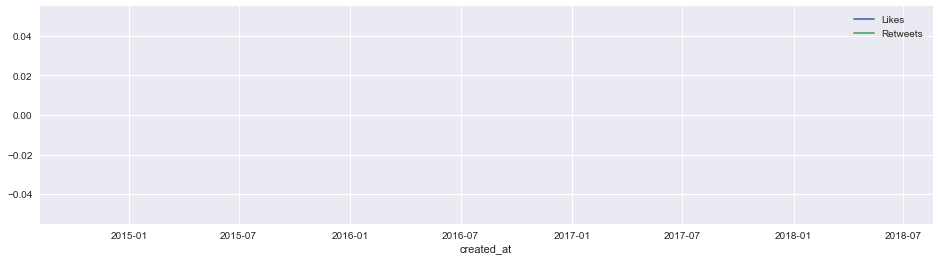

In [12]:
fav = pd.Series(data=tweets_df['likes'].values, index=tweets_df['created_at'])
ret = pd.Series(data=tweets_df['retweet_count'].values, index=tweets_df['created_at'])

fav.plot(figsize=(16,4), label="Likes", legend=True)
ret.plot(figsize=(16,4), label="Retweets", legend=True);

# Sentiment Analysis

Here we will begin sentiment analysis on the tweets. We will do this using textblob which is a NL libraby for python. First we need to clean the text before producing the sentiment score.

We will attempt to answer the question:
- What is the sentiment towards the candidates?

In [14]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    # Removes links and special characters
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    # Function to analyze sentiment
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"
    
# We create a column with the result of the analysis:
tweets_df['sentiment'] = np.array([ analize_sentiment(tweet) for tweet in tweets_df.loc[:, "text"] ])

Now that we have created the sentiments column, we get the count of the tweets by sentiment of the data we have.

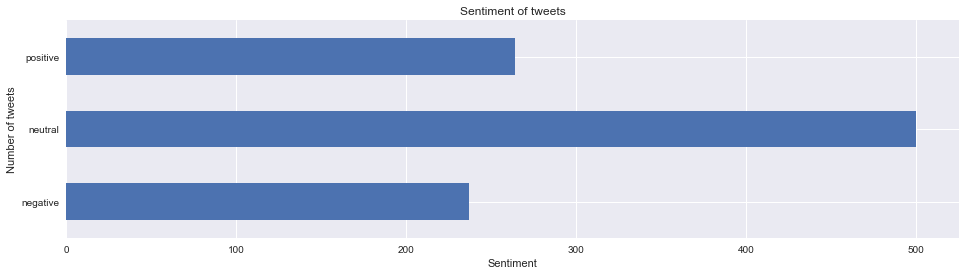

In [15]:
tweets_sentiment = (tweets_df.groupby(['sentiment'])).count().unstack('text')['text']
tweets_sentiment.plot.barh(figsize=(16,4), title = 'Sentiment of tweets', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

### Tweets Sentiment by candidate

Here we plot the sentiment by candidate mention.

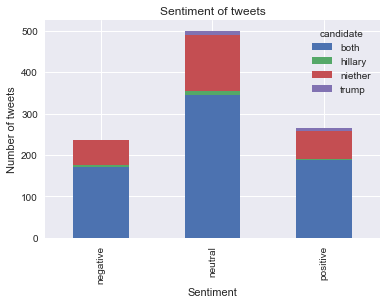

In [18]:
tweets_sentiment = (tweets_df.groupby(['sentiment'])).count().unstack('candidate')['text']
class_ct = pd.crosstab(tweets_df.sentiment, tweets_df.candidate, margins=True)
class_ct = class_ct.drop('All', 1)
class_ct[:3].plot(title = 'Sentiment of tweets', kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

From the above graph, it is hard to drive any knowledge regarding the candidates since tweets mentioning both are overwhelming in number. However, it seems that neutral tweets are much more than positive or negative tweets. 

For the next step we exclude tweets that mention both or neither.

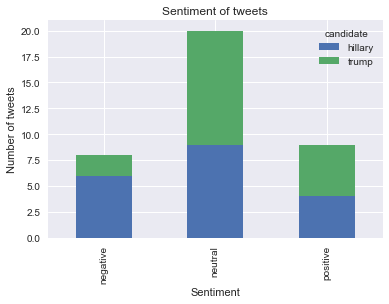

In [19]:
class_ct = class_ct.drop('both', 1)
class_ct = class_ct.drop('niether', 1)
class_ct[:3].plot(title = 'Sentiment of tweets', kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

In a surprising turn of events. It seems that Trump has more positive tweets than negative, while Hillary is getting more negative tweets than positive.

In [ ]:
plt.plot(tweets_df['created_at'], tweets_df['text'])

In [20]:
class_ct[:3]

candidate,hillary,trump
sentiment,,
negative,6,2
neutral,9,11
positive,4,5
